In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [49]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 5

START_DATE = "20240101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "interm/events"
SIDES_DIR = BASE_DIR / "interm/sides"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_FEATURES.pkl"

## Loading Data

In [50]:
%%time
df = pd.read_pickle(PROCESSED_FILE_PATH)

CPU times: user 2.01 ms, sys: 18.7 ms, total: 20.7 ms
Wall time: 20.2 ms


In [51]:
df.shape

(73782, 67)

In [52]:
df.head()

,open,high,low,close,volume,spread,close_pct_return,close_return,close_log_return,close_fd_return,...,dom,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-05 03:25:00,144.8960,144.9415,144.8940,144.9105,2.780660e+12,0.006927,0.000100,0.0145,0.000100,2.788711,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025
2024-01-05 03:30:00,144.9100,144.9490,144.9060,144.9470,2.220040e+12,0.006398,0.000252,0.0365,0.000252,2.810244,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025
2024-01-05 03:35:00,144.9465,144.9490,144.9230,144.9240,3.450710e+12,0.006930,-0.000159,-0.0230,-0.000159,2.762497,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025
2024-01-05 03:40:00,144.9245,144.9460,144.9155,144.9430,2.273510e+12,0.007072,0.000131,0.0190,0.000131,2.784171,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025
2024-01-05 03:45:00,144.9435,144.9510,144.9355,144.9465,1.925300e+12,0.006585,0.000024,0.0035,0.000024,2.775585,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025


## Calculating MACD

In [ ]:
import pandas_ta as ta

FAST = 12 #(45 min)
SLOW = 26 #(180 min)
SIGNAL = 9

df.ta.macd(fast=FAST, slow=SLOW, signal=SIGNAL, append=True)

df['future_return'] = np.log(df['close']).diff().shift(-1)

## Generate Signals

df['signal'] = np.where(df[f"MACD_{FAST}_{SLOW}_{SIGNAL}"] > df[f'MACDs_{FAST}_{SLOW}_{SIGNAL}'], 1, -1)

df['signal']

## Simple Testing

df['strategy_return'] = df['signal'] * df['future_return']

r = df['strategy_return']
profit_factor = r[r>0].sum() / r[r<0].abs().sum()
sharpe_ratio = r.mean() / r.std()

print('Profit Factor:', profit_factor)
print('Sharpe Ratio:', sharpe_ratio)

## Optimize the strategy

This strategy has 3 parameters: fast, slow, signal

We can optimize the strategy by finding the best combination

Top 10 Parameter Combinations by Sharpe Ratio:
 fast  slow  signal  profit_factor  sharpe_ratio  total_return  win_rate  num_trades
    9    20       9       1.013549      0.003866      0.111176  0.488107       73781
   13    30       5       1.013380      0.003818      0.109796  0.487077       73781
   13    22       5       1.013353      0.003810      0.109571  0.487632       73781
    9    34       5       1.013059      0.003727      0.107182  0.488540       73781
    5    22      13       1.013032      0.003719      0.106961  0.487592       73781
    7    38       7       1.012971      0.003702      0.106460  0.487510       73781
   11    24       7       1.012873      0.003674      0.105660  0.487592       73781
    5    34       9       1.012788      0.003650      0.104964  0.488513       73781
    5    30      13       1.012706      0.003627      0.104297  0.487009       73781
   15    20       5       1.012615      0.003601      0.103559  0.487470       73781


Top 10 Parameter

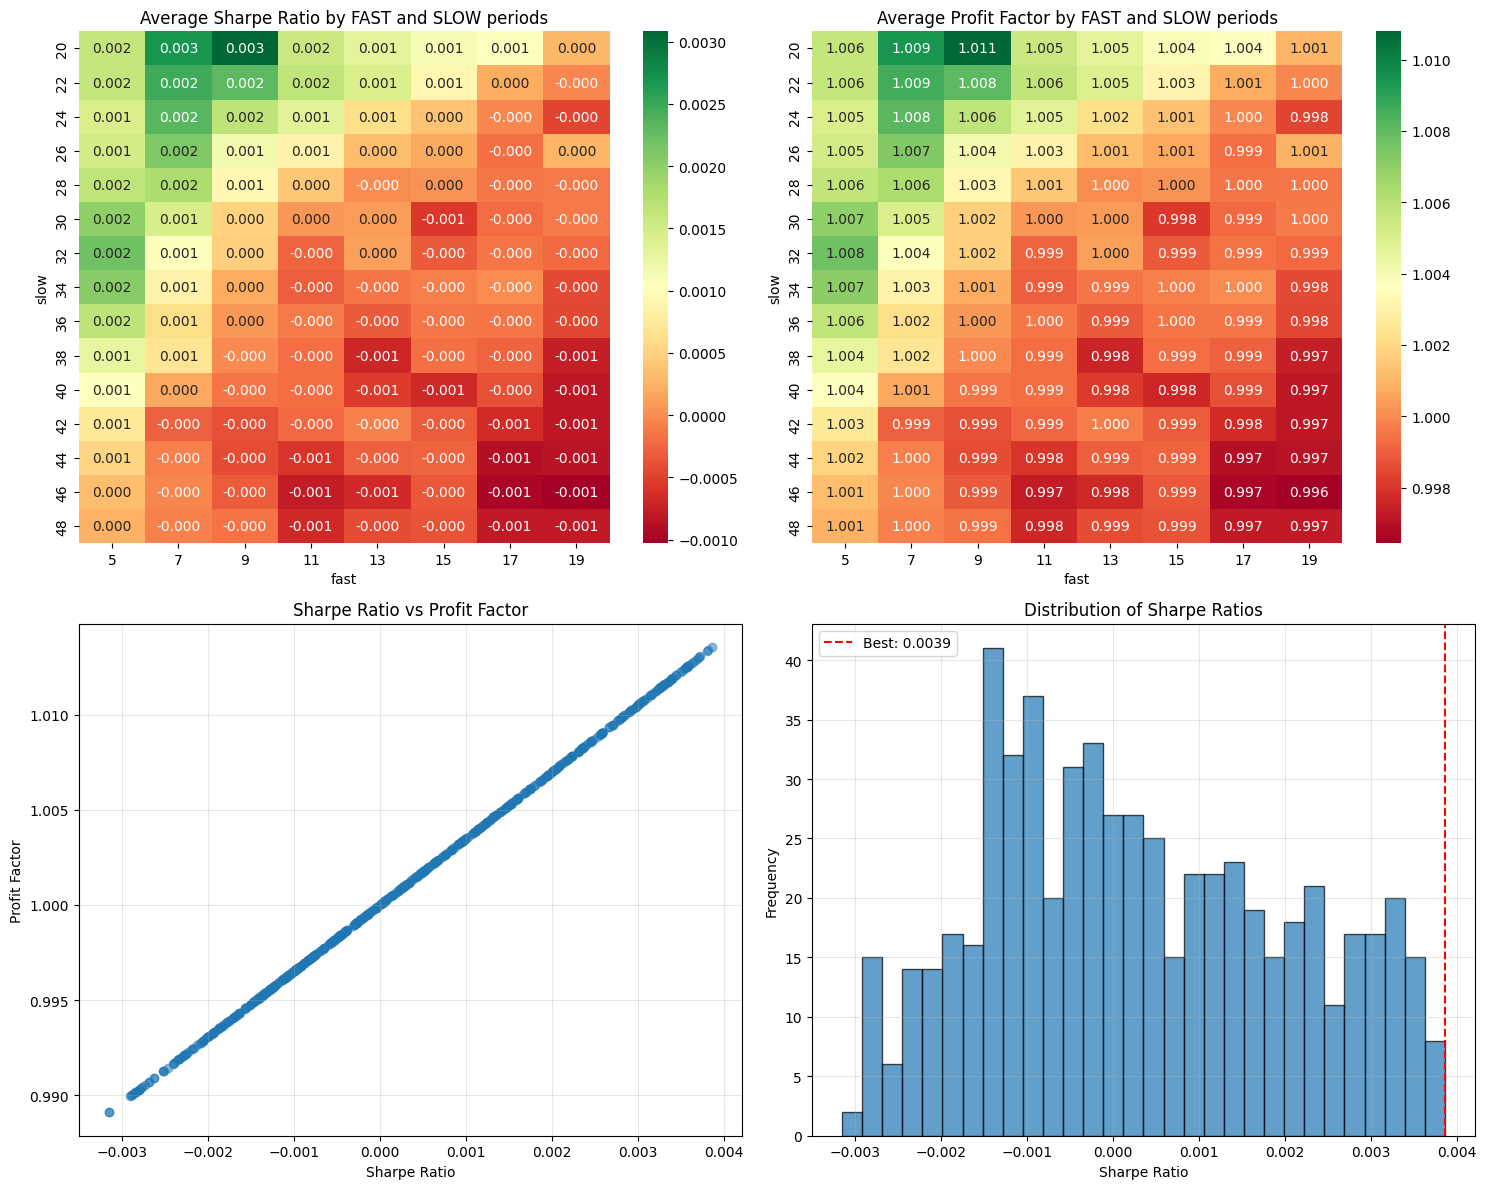

In [64]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter ranges to test
fast_range = range(5, 20, 2)      # 8, 10, 12, 14, 16, 18
slow_range = range(20, 50, 2)     # 20, 22, 24, 26, 28, 30, 32, 34
signal_range = range(5, 15, 2)    # 5, 7, 9, 11, 13

# Store results
results = []

# Grid search optimization
for fast, slow, signal in product(fast_range, slow_range, signal_range):
    # Skip invalid combinations where fast >= slow
    if fast >= slow:
        continue
    
    # Create a copy of dataframe for testing
    df_test = df.copy()
    
    # Calculate MACD
    df_test.ta.macd(fast=fast, slow=slow, signal=signal, append=True)
    
    # Calculate future returns
    df_test['future_return'] = np.log(df_test['close']).diff().shift(-1)
    
    # Generate signals
    df_test['signal'] = np.where(
        df_test[f"MACD_{fast}_{slow}_{signal}"] > df_test[f'MACDs_{fast}_{slow}_{signal}'], 
        1, -1
    )
    
    # Calculate strategy returns
    df_test['strategy_return'] = df_test['signal'] * df_test['future_return']
    
    # Calculate metrics
    r = df_test['strategy_return'].dropna()
    
    if len(r) > 0 and r[r < 0].abs().sum() != 0:
        profit_factor = r[r > 0].sum() / r[r < 0].abs().sum()
        sharpe_ratio = r.mean() / r.std() if r.std() != 0 else 0
        total_return = r.sum()
        win_rate = len(r[r > 0]) / len(r)
        
        results.append({
            'fast': fast,
            'slow': slow,
            'signal': signal,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe_ratio,
            'total_return': total_return,
            'win_rate': win_rate,
            'num_trades': len(r)
        })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort by Sharpe Ratio (or any metric you prefer)
results_df = results_df.sort_values('sharpe_ratio', ascending=False)

# Display top 10 parameter combinations
print("Top 10 Parameter Combinations by Sharpe Ratio:")
print(results_df.head(10).to_string(index=False))

print("\n" + "="*80 + "\n")

# Display top 10 by Profit Factor
print("Top 10 Parameter Combinations by Profit Factor:")
print(results_df.sort_values('profit_factor', ascending=False).head(10).to_string(index=False))

# Get the best parameters
best_params = results_df.iloc[0]
print("\n" + "="*80 + "\n")
print("Best Parameters (by Sharpe Ratio):")
print(f"FAST: {int(best_params['fast'])}")
print(f"SLOW: {int(best_params['slow'])}")
print(f"SIGNAL: {int(best_params['signal'])}")
print(f"Sharpe Ratio: {best_params['sharpe_ratio']:.4f}")
print(f"Profit Factor: {best_params['profit_factor']:.4f}")
print(f"Total Return: {best_params['total_return']:.4f}")
print(f"Win Rate: {best_params['win_rate']:.2%}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Heatmap: Sharpe Ratio vs Fast/Slow (averaged over signal values)
pivot_sharpe = results_df.groupby(['fast', 'slow'])['sharpe_ratio'].mean().reset_index()
pivot_sharpe = pivot_sharpe.pivot(index='slow', columns='fast', values='sharpe_ratio')
sns.heatmap(pivot_sharpe, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 0])
axes[0, 0].set_title('Average Sharpe Ratio by FAST and SLOW periods')

# 2. Heatmap: Profit Factor vs Fast/Slow
pivot_pf = results_df.groupby(['fast', 'slow'])['profit_factor'].mean().reset_index()
pivot_pf = pivot_pf.pivot(index='slow', columns='fast', values='profit_factor')
sns.heatmap(pivot_pf, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0, 1])
axes[0, 1].set_title('Average Profit Factor by FAST and SLOW periods')

# 3. Scatter plot: Sharpe vs Profit Factor
axes[1, 0].scatter(results_df['sharpe_ratio'], results_df['profit_factor'], alpha=0.5)
axes[1, 0].set_xlabel('Sharpe Ratio')
axes[1, 0].set_ylabel('Profit Factor')
axes[1, 0].set_title('Sharpe Ratio vs Profit Factor')
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of Sharpe Ratios
axes[1, 1].hist(results_df['sharpe_ratio'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(best_params['sharpe_ratio'], color='red', linestyle='--', 
                    label=f"Best: {best_params['sharpe_ratio']:.4f}")
axes[1, 1].set_xlabel('Sharpe Ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Sharpe Ratios')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Reproduce the strategy with optimized parameters

In [65]:
import pandas_ta as ta

FAST = 9 #(45 min)
SLOW = 20 #(100 min)
SIGNAL = 9

df.ta.macd(fast=FAST, slow=SLOW, signal=SIGNAL, append=True)

df['future_return'] = np.log(df['close']).diff().shift(-1)

## Generate Signals

df['signal'] = np.where(df[f"MACD_{FAST}_{SLOW}_{SIGNAL}"] > df[f'MACDs_{FAST}_{SLOW}_{SIGNAL}'], 1, -1)

df['signal']

## Simple Testing

df['strategy_return'] = df['signal'] * df['future_return']

r = df['strategy_return']
profit_factor = r[r>0].sum() / r[r<0].abs().sum()
sharpe_ratio = r.mean() / r.std()

print('Profit Factor:', profit_factor)
print('Sharpe Ratio:', sharpe_ratio)

Profit Factor: 1.013549405237585
Sharpe Ratio: 0.0038658219941127116


## Finding Cross Points

找到跨越的時間點（t_events）

In [73]:
df['signal'].value_counts()

signal
-1    37409
 1    36373
Name: count, dtype: int64

In [74]:
# find crossover events
t_events = df.index[df['signal'] != df['signal'].shift(1)]
t_events

DatetimeIndex(['2024-01-05 03:25:00', '2024-01-05 05:55:00',
               '2024-01-05 07:10:00', '2024-01-05 08:40:00',
               '2024-01-05 10:40:00', '2024-01-05 11:20:00',
               '2024-01-05 11:30:00', '2024-01-05 13:05:00',
               '2024-01-05 14:10:00', '2024-01-05 15:50:00',
               ...
               '2024-12-30 12:55:00', '2024-12-30 13:50:00',
               '2024-12-30 14:20:00', '2024-12-30 14:30:00',
               '2024-12-30 15:40:00', '2024-12-30 17:25:00',
               '2024-12-30 19:20:00', '2024-12-30 20:25:00',
               '2024-12-30 21:35:00', '2024-12-30 23:55:00'],
              dtype='datetime64[ns]', name='timestamp', length=6859, freq=None)

## Labeling Sides

黃金交叉與死亡交叉

In [76]:
sides = pd.Series(df['signal'].loc[t_events], index=t_events, name='side')
sides

timestamp
2024-01-05 03:25:00   -1
2024-01-05 05:55:00    1
2024-01-05 07:10:00   -1
2024-01-05 08:40:00    1
2024-01-05 10:40:00   -1
                      ..
2024-12-30 17:25:00   -1
2024-12-30 19:20:00    1
2024-12-30 20:25:00   -1
2024-12-30 21:35:00    1
2024-12-30 23:55:00   -1
Name: side, Length: 6859, dtype: int64

In [77]:
sides.value_counts()

side
-1    3430
 1    3429
Name: count, dtype: int64

## Saving to disk

In [81]:
SIDE_NAME = f"MACDCross_{FAST}_{SLOW}_{SIGNAL}"

In [82]:
SIDE_FILE_PATH = SIDES_DIR / f"{RESAMPLED_NAME}-{SIDE_NAME}.pkl"
SIDE_FILE_PATH

PosixPath('../data/interm/sides/USDJPY-5m-20240101-20241231-MACDCross_9_20_9.pkl')

In [83]:
sides.to_pickle(SIDE_FILE_PATH)